In [2]:
%pip install geoplot


import json
import numpy as np
import pandas as pd
import plotly.express as px

import geopandas as gpd
import geoplot
import geoplot.crs as gcrs

from shapely.geometry import Point
from shapely import unary_union, intersection

from matplotlib.patches import Polygon, Circle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 14.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:

states_df = gpd.read_file(
    "/Users/filippuzic/Desktop/DS311/us-states.json"
)

states_df = states_df.query('name not in ["Alaska", "Hawaii", "Puerto Rico"]')
states_df.head()


,id,name,density,geometry
0,01,Alabama,94.65,"POLYGON ((-87.3593 35.00118, -85.60668 34.9847..."
2,04,Arizona,57.05,"POLYGON ((-109.0425 37.00026, -109.04798 31.33..."
3,05,Arkansas,56.43,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.70,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."
5,08,Colorado,49.33,"POLYGON ((-107.91973 41.00391, -105.72895 40.9..."


In [4]:
# Load the data from the specified file path
file_path = '/Users/filippuzic/Downloads/alt_fuel_stations (Apr 9 2025).csv'
df = pd.read_csv(file_path)

# Filter only electric stations with valid coordinates
df_elec = df[(df['Fuel Type Code'] == 'ELEC') & df['Latitude'].notnull() & df['Longitude'].notnull()][['Longitude','Latitude']]

# Calculate the radius scale in miles based on latitude
milesPerDegLongEquator = 69.17
df_elec['radius_scale_miles'] = np.cos(np.pi*df_elec['Latitude']/180)/milesPerDegLongEquator

/var/folders/pp/p8p9srjs4zq31gjk2wkq4wxh0000gn/T/ipykernel_52166/3873303448.py:3: DtypeWarning: Columns (6,20,31,46,69,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
# Create a polygon of just the outline of the USA
us_outline = unary_union(list(states_df['geometry']))

In [6]:
circles = {}
polys = {}
poly_list = {}

# distance from nearest fuel point (in miles)
radii = [100, 20, 4] 
  
for radius in radii:
    # Create all the circles with a specified radius
    circles[radius] = [Point(x, y).buffer(r) for x, y, r in zip(df_elec['Longitude'], df_elec['Latitude'], radius*df_elec['radius_scale_miles'])]
    
    # Combine the circles into one polygon
    polys[radius] = unary_union(circles[radius])
    
    # Remove the parts of the polygon that are outside of the US
    polys[radius] = intersection(polys[radius], us_outline)
    
    if polys[radius].geom_type == 'MultiPolygon':
        poly_list[radius] = list(polys[radius].geoms)
    else:
        poly_list[radius] = [polys[radius]]

5
389
3956


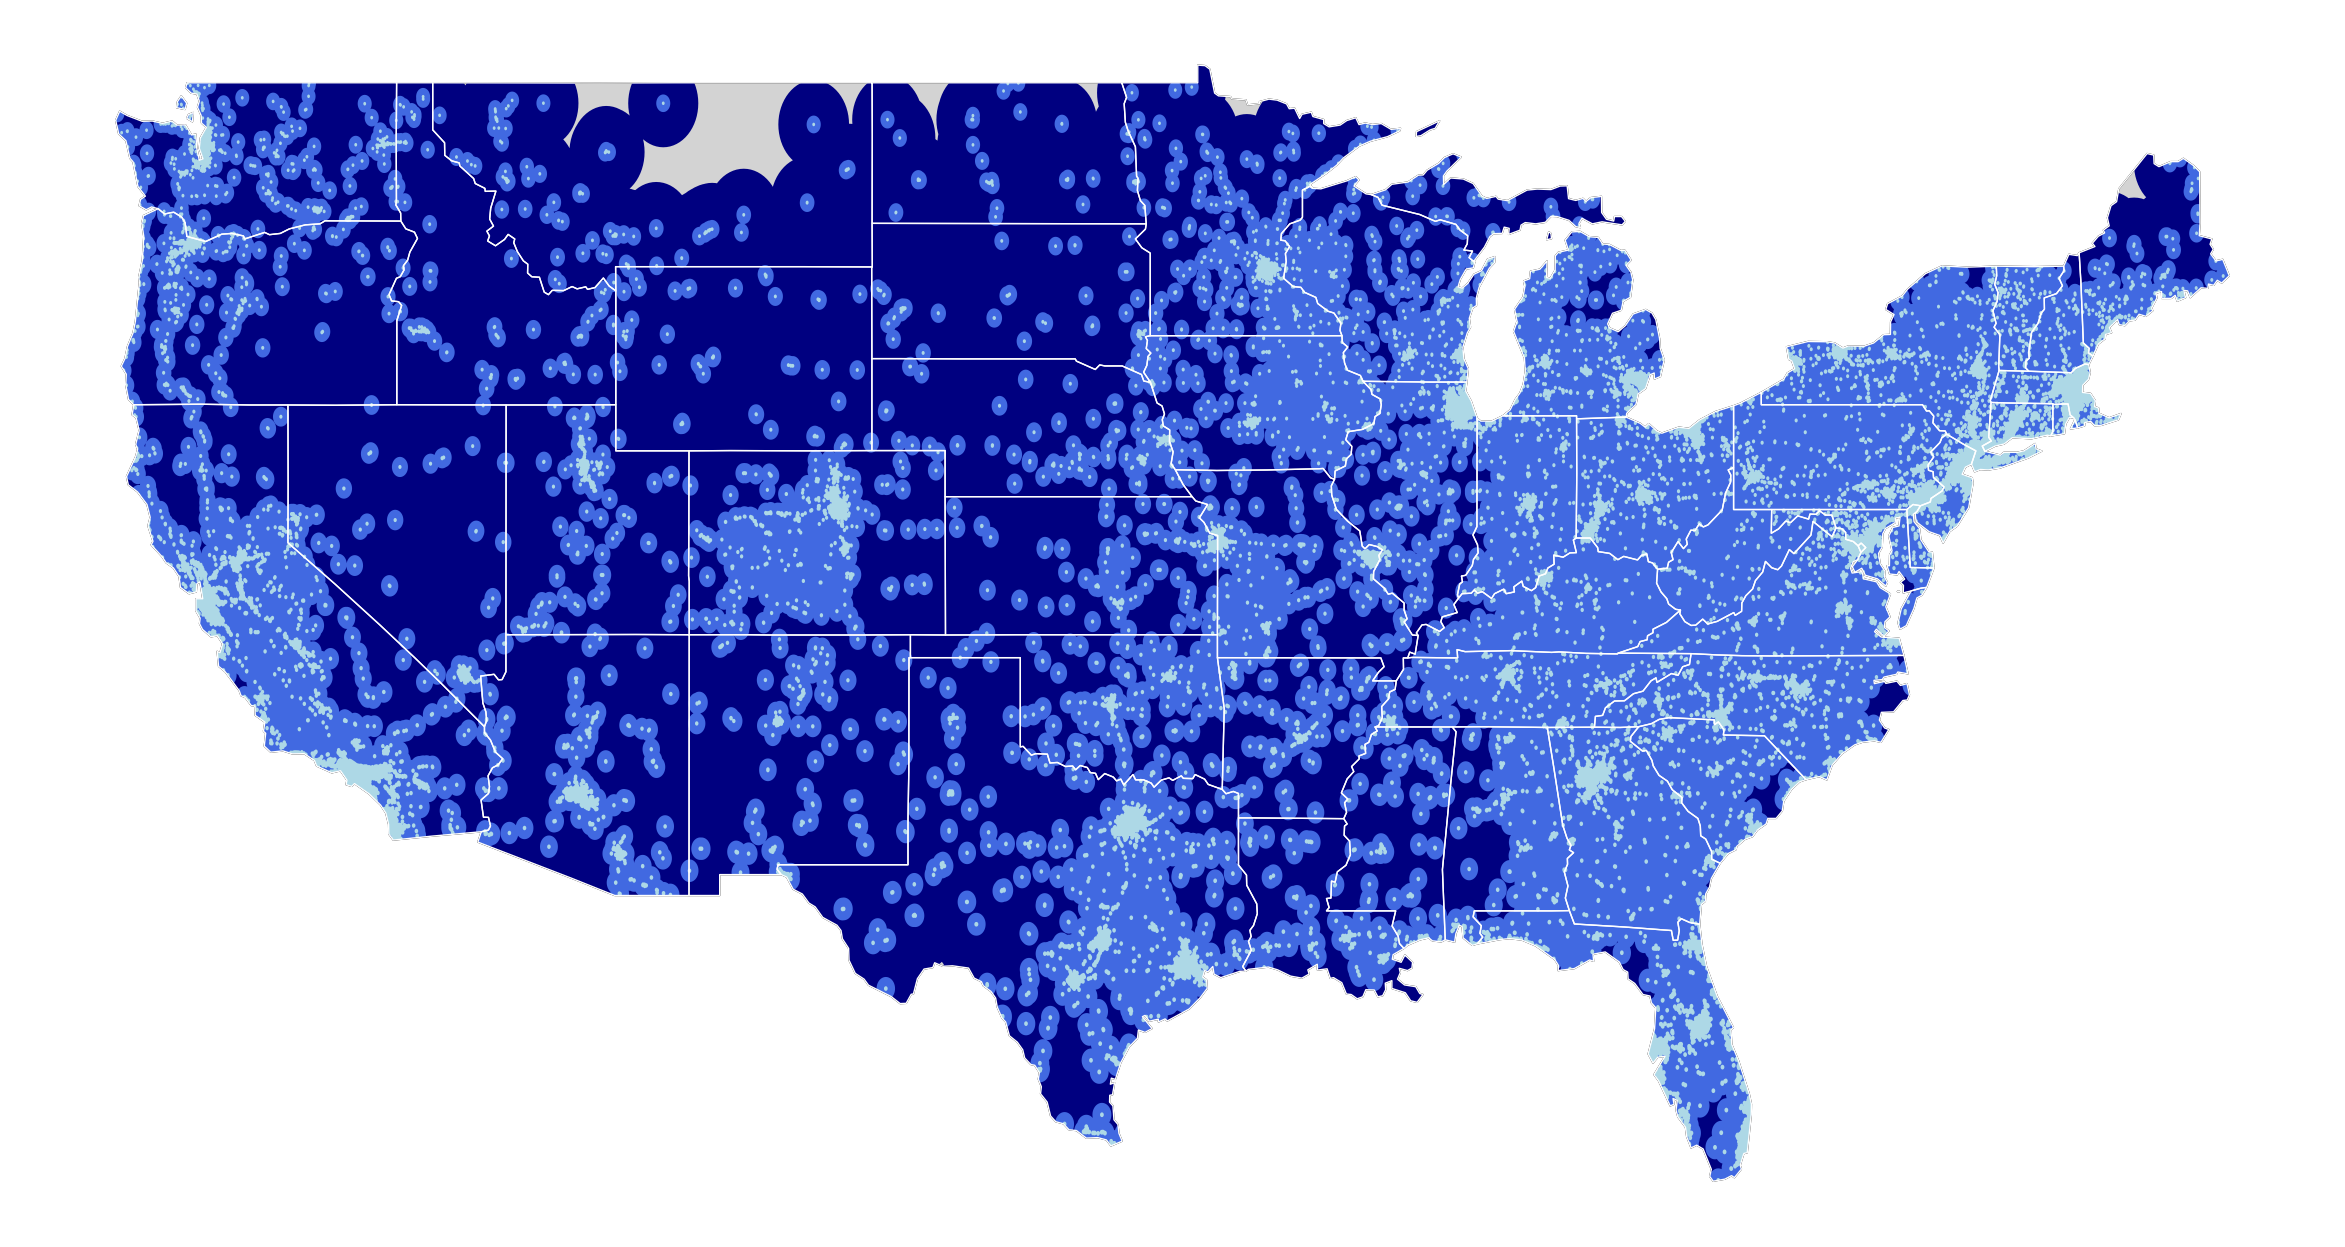

In [10]:
fig, ax = plt.subplots(1,1,figsize = (30,20))

states_df.plot(edgecolor='k', facecolor='lightgray', ax=ax)

# Colors for the different distances
# level_colors = ['firebrick', 'tomato', 'peachpuff']
level_colors = ['navy', 'royalblue', 'lightblue']
# level_colors = ['darkgreen', 'mediumseagreen', 'palegreen']

for polygon_list, level_color in zip(poly_list.values(), level_colors):
    print(len(polygon_list))
    for poly in polygon_list:
        x, y = poly.exterior.coords.xy
        polygon_patch = Polygon(list(zip(x, y)), edgecolor = None, facecolor = level_color, closed=True, alpha=1)
        ax.add_patch(polygon_patch)

# If you want to have outline of states on top of data
states_df.plot(edgecolor='w', facecolor='none', ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.spines[:].set_visible(False)
ax.set_facecolor('none')
fig.set_facecolor('none')

plt.savefig('map.svg', transparent = True)
plt.show()